In [16]:
import os
import sys

# Clone the SoccerTrack repository
if not os.path.isdir("/content/SoccerTrack"):
    print("Cloning SoccerTrack repository...")
    os.system("git clone https://github.com/JulezKlein/SoccerTrack.git /content/SoccerTrack")
    print("✓ Repository cloned")
else:
    print("✓ SoccerTrack repository already exists")

# Change to repo directory
os.chdir("/content/SoccerTrack")
sys.path.insert(0, "/content/SoccerTrack")

✓ SoccerTrack repository already exists


In [17]:
# Configuration
DATASET = "football"  # Change to "soccertrack" if using that dataset
VIEW_TYPE = "top_view"  # Only relevant for soccertrack ("top_view" or "wide_view")
MODEL = "rtdetr-l"  # Options: yolov8s, yolov8n, yolo26n, rtdetr-l, rtdetr-x
EPOCHS = 70
IMG_SIZE = 640

# Mount Google Drive (for Colab data access)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")
    DATA_DIR = "/content/drive/MyDrive/datasets"
except:
    print("⚠ Google Colab not detected - running in local environment")
    DATA_DIR = "./data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted


In [18]:
import torch

print("\n" + "="*60)
print("Environment Setup")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device available: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA available: True")
    os.system("nvidia-smi")
else:
    print("CUDA available: False")


Environment Setup
PyTorch version: 2.9.0+cu128
Device available: cuda
GPU: Tesla T4
CUDA available: True


In [19]:
# Install dependencies
print("\n" + "="*60)
print("Installing Dependencies")
print("="*60)

import subprocess
import sys

subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade", "pip", "-q"], check=True)
subprocess.run(
    [sys.executable, "-m", "pip", "install",
     "ultralytics", "pandas", "pillow", "tqdm", "opencv-python", "matplotlib", "-q"],
    check=True
)
print("✓ Dependencies installed")


Installing Dependencies
✓ Dependencies installed


In [20]:
# Import training functions and CONFIG from the script
from train_ultralytics_models import (
    unzip_dataset,
    prepare_dataset,
    validate_dataset,
    visualize_sample,
    start_training
)
import train_ultralytics_models as training_module

# Configure dataset using DATA_DIR paths
print("\n" + "="*60)
print(f"Configuring Dataset: {DATASET.upper()}")
print("="*60)

# Update DATASET_CONFIGS in the training module to use DATA_DIR
training_module.DATASET_CONFIGS["soccertrack"]["data_dir"] = DATA_DIR
training_module.DATASET_CONFIGS["soccertrack"]["dataset_zip"] = f"{DATA_DIR}/soccertrack.zip"
training_module.DATASET_CONFIGS["soccertrack"]["dataset_dir"] = f"{DATA_DIR}/soccertrack"
training_module.DATASET_CONFIGS["soccertrack"]["prep_dir"] = f"{DATA_DIR}/soccertrack_prep_{VIEW_TYPE}"
training_module.DATASET_CONFIGS["soccertrack"]["output_dir"] = f"{DATA_DIR}/output_yolo_soccertrack"

training_module.DATASET_CONFIGS["football"]["data_dir"] = DATA_DIR
training_module.DATASET_CONFIGS["football"]["dataset_dir"] = f"{DATA_DIR}/football_player_detection"
training_module.DATASET_CONFIGS["football"]["output_dir"] = f"{DATA_DIR}/output_{MODEL}_football"
training_module.DATASET_CONFIGS["football"]["yaml_path"] = f"{DATA_DIR}/football_player_detection/data.yaml"

# Configure dataset
config = training_module.configure_dataset(dataset_type=DATASET, view_type=VIEW_TYPE)


Configuring Dataset: FOOTBALL

✓ Configuration loaded for 'football' dataset
  - Dataset directory: /content/drive/MyDrive/datasets/football_player_detection
  - Output directory: /content/drive/MyDrive/datasets/output_rtdetr-l_football
  - Requires preparation: False


In [21]:
# Prepare dataset (only if needed for SoccerTrack)
print("\n" + "="*60)
print("Dataset Preparation")
print("="*60)

if config["requires_preparation"]:
    print(f"Preparing {DATASET} dataset for training...")
    unzip_dataset()
    prepare_dataset()
    print("✓ Dataset preparation complete")
else:
    print(f"✓ {DATASET} dataset is already in expected format")
    print("  No preparation needed - data should be uploaded to:")
    print(f"  {config['dataset_dir']}")


Dataset Preparation
✓ football dataset is already in expected format
  No preparation needed - data should be uploaded to:
  /content/drive/MyDrive/datasets/football_player_detection



Visualizing Sample
Visualizing: Capture179_PNG_jpg.rf.f452d55b8e4138707b1c70cdd1e6b6c2.jpg


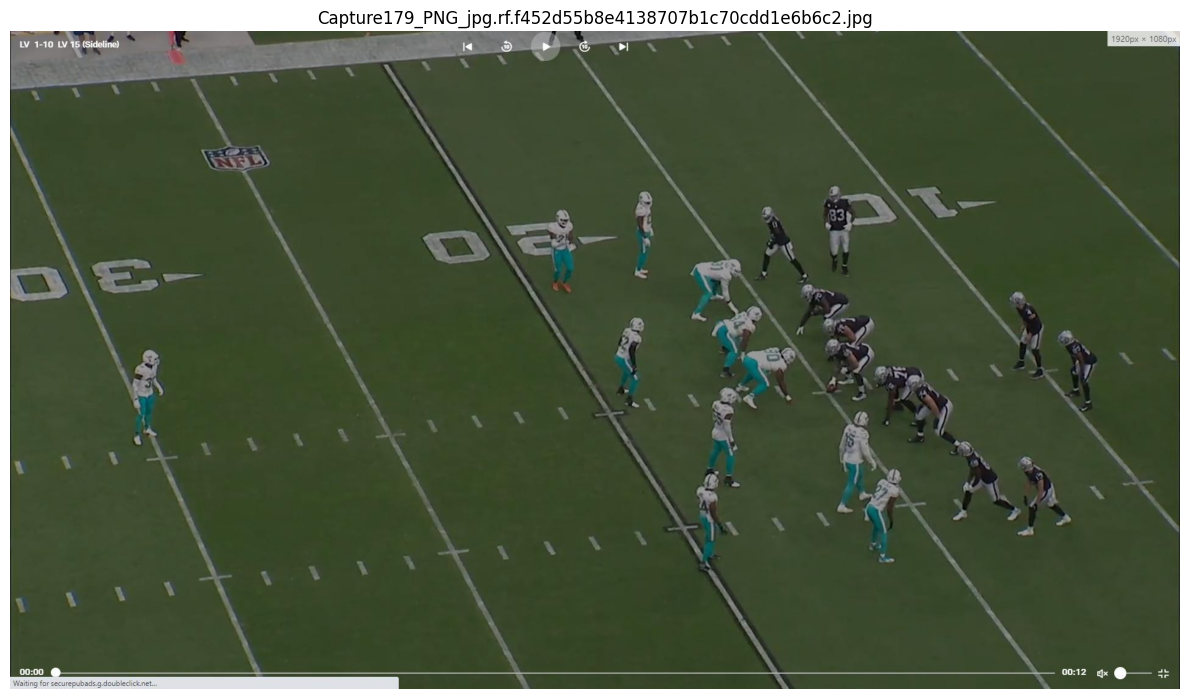

✓ Sample visualization complete


In [22]:
# Visualize sample from dataset
print("\n" + "="*60)
print("Visualizing Sample")
print("="*60)

try:
    visualize_sample()
    print("✓ Sample visualization complete")
except Exception as e:
    print(f"⚠ Could not visualize sample: {e}")

In [23]:
# Validate dataset before training
print("\n" + "="*60)
print("Validating Dataset Format")
print("="*60)

try:
    validate_dataset()
    print("✓ Dataset validation successful")
except Exception as e:
    print(f"⚠ Validation warning: {e}")
    print("  Proceeding with training anyway...")


Validating Dataset Format

Validating dataset format...

Validating training set...
✓ Dataset validation passed: 21265 valid annotations in /content/drive/MyDrive/datasets/football_player_detection/train/labels

Validating validation set...
✓ Dataset validation passed: 7640 valid annotations in /content/drive/MyDrive/datasets/football_player_detection/valid/labels

✓ Dataset validation complete!
✓ Dataset validation successful


In [24]:
# Print training configuration
print("\n" + "="*60)
print("Training Configuration")
print("="*60)
print(f"Dataset: {DATASET}")
if DATASET == "soccertrack":
    print(f"View Type: {VIEW_TYPE}")
print(f"Model: {MODEL}")
print(f"Epochs: {EPOCHS}")
print(f"Image Size: {IMG_SIZE}")
print(f"Device: {device}")
print(f"Output Dir: {config['output_dir']}")
print("="*60)


Training Configuration
Dataset: football
Model: rtdetr-l
Epochs: 70
Image Size: 640
Device: cuda
Output Dir: /content/drive/MyDrive/datasets/output_rtdetr-l_football


In [25]:
# Start training
print("\n" + "="*60)
print(f"Starting {MODEL.upper()} Training")
print("="*60)

try:
    results = start_training(
        epochs=EPOCHS,
        img_size=IMG_SIZE,
        model_name=MODEL
    )
    print("\n✅ Training completed successfully!")
    print(f"Results saved to: {config['output_dir']}/{MODEL}")
except Exception as e:
    print(f"\n❌ Training failed: {e}")
    import traceback
    traceback.print_exc()


Starting RTDETR-L Training
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

Starting RTDETR-L training...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=False, angle=1.0, augment=True, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/datasets/football_player_detection/data.yaml, degrees=0.0, deterministic=False, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, 

In [26]:
# Optional: Check training results
import glob
from pathlib import Path

output_dir = Path(config['output_dir']) / MODEL
if output_dir.exists():
    print("\n" + "="*60)
    print("Training Results")
    print("="*60)

    # List results directories
    result_dirs = list(output_dir.glob("train*"))
    if result_dirs:
        latest_run = max(result_dirs, key=lambda p: p.stat().st_mtime)
        print(f"Latest training run: {latest_run.name}")

        # List key files
        weights_dir = latest_run / "weights"
        if weights_dir.exists():
            print(f"\nWeights:")
            for weight_file in weights_dir.glob("*.pt"):
                print(f"  - {weight_file.name}")

        # Check for results.csv
        results_csv = latest_run / "results.csv"
        if results_csv.exists():
            print(f"\n✓ Results logged to: {results_csv}")
    else:
        print("No completed training runs found yet")


Training Results
Latest training run: train_batch3482.jpg


In [27]:
# Optional: Download trained model from Colab
try:
    from google.colab import files

    weights_path = output_dir / "train" / "weights" / "best.pt"
    if weights_path.exists():
        print(f"\nDownloading trained model: {weights_path.name}")
        files.download(str(weights_path))
        print("✓ Model download started")
    else:
        print("No trained weights found to download")
except ImportError:
    print("(Google Colab environment not detected - skipping download)")

No trained weights found to download


In [34]:
# ============================================================
# EXPORT CONFIGURATION
# ============================================================
# Choose export format(s): "coreml", "onnx", or "both"
EXPORT_FORMAT = "both"  # Change to "onnx" or "both" as needed
EXPORT_FP16 = True  # Use FP16 precision (False for FP32)
DISABLE_NMS = False  # Set True to disable NMS in exported model

CONF_THRESH = 0.4  # Confidence threshold baked into model
IOU_THRESH = 0.2   # IoU threshold baked into model

# Find the best weights from training
from pathlib import Path
import glob

output_path = Path(config['output_dir']) / MODEL

WEIGHTS = f"/content/drive/MyDrive/datasets/output_rtdetr-l_football/{MODEL}/weights/best.pt"
print(f"Using default weights path: {WEIGHTS}")

print(f"\nExport Configuration:")
print(f"  Format: {EXPORT_FORMAT}")
print(f"  FP16: {EXPORT_FP16}")
print(f"  NMS: {not DISABLE_NMS}")
print(f"  Conf Threshold: {CONF_THRESH}")
print(f"  IoU Threshold: {IOU_THRESH}")

Using default weights path: /content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights/best.pt

Export Configuration:
  Format: both
  FP16: True
  NMS: True
  Conf Threshold: 0.4
  IoU Threshold: 0.2


In [35]:
# ============================================================
# EXPORT FUNCTIONS
# ============================================================
import os
import time
from PIL import Image
import numpy as np
from ultralytics import YOLO, RTDETR

def export_coreml():
    """Export model to Core ML format"""
    print("🔄 Loading YOLO / RTDETR model...")
    model = YOLO(WEIGHTS) if MODEL.startswith('yolo') else RTDETR(WEIGHTS)

    print("📦 Exporting to Core ML...")
    try:
        model.export(
            format="coreml",
            imgsz=IMG_SIZE,
            nms=not DISABLE_NMS,
            half=EXPORT_FP16,
            conf=CONF_THRESH,
            iou=IOU_THRESH,
            data=config['yaml_path']
        )
        print("✅ Core ML export finished")
        return True
    except Exception as e:
        print(f"❌ Core ML export failed: {e}")
        return False


def export_onnx():
    """Export model to ONNX format"""
    print("🔄 Loading YOLO / RTDETR model...")
    model = YOLO(WEIGHTS) if MODEL.startswith('yolo') else RTDETR(WEIGHTS)

    print("📦 Exporting to ONNX...")
    try:
        model.export(
            format="onnx",
            imgsz=IMG_SIZE,
            nms=not DISABLE_NMS,
            end2end=True,
            conf=CONF_THRESH,
            iou=IOU_THRESH,
            half=EXPORT_FP16,
            data=config['yaml_path']
        )
        print("✅ ONNX export finished")
        return True
    except Exception as e:
        print(f"❌ ONNX export failed: {e}")
        return False


def quick_test_coreml():
    """Test Core ML model with dummy input"""
    print("\n🧪 Running Core ML inference test...")

    try:
        import coremltools as ct
    except ImportError:
        print("⚠️ coremltools not installed. Installing...")
        os.system("pip install coremltools -q")
        import coremltools as ct

    mlpackage_path = WEIGHTS.replace(".pt", ".mlpackage")

    if not os.path.exists(mlpackage_path):
        print(f"⚠️ Core ML model not found at {mlpackage_path}")
        return

    try:
        mlmodel = ct.models.MLModel(mlpackage_path)
        print("✓ Core ML model loaded successfully")
    except Exception as e:
        print(f"❌ Failed to load Core ML model: {e}")
        return

    dummy_input = Image.new(mode="RGB", size=(IMG_SIZE, IMG_SIZE), color=(128, 128, 128))

    try:
        outputs = mlmodel.predict({"image": dummy_input})
        print("✅ Core ML inference successful")
        print("📤 Output keys:")
        for k, v in outputs.items():
            try:
                print(f"  - {k}: {v.shape}")
            except:
                print(f"  - {k}: (non-array output)")
    except Exception as e:
        print(f"❌ Core ML inference failed: {e}")
        return

    try:
        t0 = time.perf_counter()
        _ = mlmodel.predict({"image": dummy_input})
        t1 = time.perf_counter()
        elapsed_ms = (t1 - t0) * 1000.0
        print(f"⏱️ Core ML inference time: {elapsed_ms:.2f} ms")
    except Exception as e:
        print(f"❌ Core ML timing failed: {e}")


def quick_test_onnx():
    """Test ONNX model with dummy input"""
    print("\n🧪 Running ONNX runtime inference test...")

    try:
        import onnxruntime as ort
    except ImportError:
        print("⚠️ onnxruntime not installed. Installing...")
        os.system("pip install onnxruntime -q")
        import onnxruntime as ort

    onnx_path = WEIGHTS.replace(".pt", ".onnx")

    if not os.path.exists(onnx_path):
        print(f"⚠️ ONNX model not found at {onnx_path}")
        return

    try:
        sess = ort.InferenceSession(onnx_path)
        print("✓ ONNX model loaded successfully")

        input_name = sess.get_inputs()[0].name
        dummy = np.random.rand(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)

        # Warm-up
        sess.run(None, {input_name: dummy})

        # Timed run
        t0 = time.perf_counter()
        outputs = sess.run(None, {input_name: dummy})
        t1 = time.perf_counter()
        elapsed_ms = (t1 - t0) * 1000.0

        print("✅ ONNX runtime inference successful")
        print(f"⏱️ ONNX inference time: {elapsed_ms:.2f} ms")
        print("📤 Output tensors:")
        for i, out in enumerate(outputs):
            print(f"  - output[{i}]: shape={getattr(out, 'shape', 'unknown')}")
    except Exception as e:
        print(f"❌ ONNX runtime test failed: {e}")


print("✓ Export functions defined")

✓ Export functions defined


In [36]:
# ============================================================
# RUN EXPORTS
# ============================================================
print("\n" + "="*60)
print("Model Export")
print("="*60)

fmt = EXPORT_FORMAT.strip().lower() if isinstance(EXPORT_FORMAT, str) else "coreml"

if fmt == "coreml":
    if export_coreml():
        quick_test_coreml()
elif fmt == "onnx":
    if export_onnx():
        quick_test_onnx()
elif fmt == "both":
    print("\n📦 Exporting to both formats...\n")
    if export_coreml():
        quick_test_coreml()
    print("\n" + "-"*60 + "\n")
    if export_onnx():
        quick_test_onnx()
else:
    print(f"❌ Unsupported EXPORT_FORMAT: {EXPORT_FORMAT}")
    print("   Choose 'coreml', 'onnx', or 'both'")

print("\n✅ Export pipeline complete!")


Model Export

📦 Exporting to both formats...

🔄 Loading YOLO / RTDETR model...
📦 Exporting to Core ML...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CPU (Intel Xeon CPU @ 2.00GHz)
WARNING ⚠️ 'nms=True' is not available for end2end models. Forcing 'nms=False'.
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
rt-detr-l summary: 310 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (63.2 MB)
requirements: Ultralytics requirement ['coremltools>=9.0'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 155ms
Prepared 3 packages in 558ms
Installed 3 packages in 15ms
 + cattrs==25.3.0
 + coremltools==9.0
 + pyaml==26.2.1

requirements: AutoUpdate success ✅ 1.

/usr/local/lib/python3.12/dist-packages/coremltools/optimize/torch/palettization/fake_palettize.py:82: SyntaxWarning: invalid escape sequence '\_'
  n_bits (:obj:`int`): Number of palettization bits. There would be :math:`2^{n\_bits}` unique weights in the ``LUT``.



CoreML: starting export with coremltools 9.0...


Converting PyTorch Frontend ==> MIL Ops:  26%|██▌       | 578/2240 [00:00<00:00, 2659.06 ops/s]ERROR:coremltools:

ERROR - converting 'matmul' op (located at: '11/out_w'):

Converting PyTorch Frontend ==> MIL Ops:  26%|██▌       | 584/2240 [00:00<00:00, 2617.94 ops/s]

ERROR ❌ CoreML: export failure 30.3s: In op, of type linear, named out_w, the named input `weight` must have the same data type as the named input `x`. However, weight has dtype fp32 whereas x has dtype int32.


❌ Core ML export failed: In op, of type linear, named out_w, the named input `weight` must have the same data type as the named input `x`. However, weight has dtype fp32 whereas x has dtype int32.

------------------------------------------------------------

🔄 Loading YOLO / RTDETR model...
📦 Exporting to ONNX...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CPU (Intel Xeon CPU @ 2.00GHz)
WARNING ⚠️ Head has no attribute 'end2end'.
WARNING ⚠️ 'nms=True' is not available for end2end models. Forcing 'nms=False'.
rt-detr-l summary: 310 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (63.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 13

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/jit_utils.py:303: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/symbolic_opset9.py:5353: UserWarning: Exporting aten::index operator of advanced indexing in opset 22 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, 

ONNX: slimming with onnxslim 0.1.84...
ONNX: converting to FP16...
ONNX: export success ✅ 33.5s, saved as '/content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights/best.onnx' (62.9 MB)

Export complete (39.8s)
Results saved to /content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights/best.onnx imgsz=640 half
Validate:        yolo val task=detect model=/content/drive/MyDrive/datasets/output_rtdetr-l_football/rtdetr-l/weights/best.onnx imgsz=640 data=/content/drive/MyDrive/datasets/football_player_detection/data.yaml half 
Visualize:       https://netron.app
✅ ONNX export finished

🧪 Running ONNX runtime inference test...
✓ ONNX model loaded successfully
✅ ONNX runtime inference successful
⏱️ ONNX inference time: 1764.22 ms
📤 Output tensors:
  - output[0]: shape=(1, 300, 6)

✅ Export pipeline complete!


In [37]:
# ============================================================
# DOWNLOAD EXPORTED MODELS (Colab only)
# ============================================================
try:
    from google.colab import files

    print("\n" + "="*60)
    print("Downloading Exported Models")
    print("="*60)

    files_to_download = []

    if fmt in ["coreml", "both"]:
        mlpackage_path = WEIGHTS.replace(".pt", ".mlpackage")
        if os.path.exists(mlpackage_path):
            print(f"📦 Found Core ML model: {os.path.basename(mlpackage_path)}")
            files_to_download.append(mlpackage_path)

    if fmt in ["onnx", "both"]:
        onnx_path = WEIGHTS.replace(".pt", ".onnx")
        if os.path.exists(onnx_path):
            print(f"📦 Found ONNX model: {os.path.basename(onnx_path)}")
            files_to_download.append(onnx_path)

    # Also download the best.pt weights
    pt_weights = WEIGHTS
    if os.path.exists(pt_weights):
        print(f"📦 Found PyTorch weights: {os.path.basename(pt_weights)}")
        files_to_download.append(pt_weights)

    if files_to_download:
        print(f"\n📥 Downloading {len(files_to_download)} file(s)...")
        for file_path in files_to_download:
            print(f"  → {os.path.basename(file_path)}")
            files.download(file_path)
        print("✅ Download complete!")
    else:
        print("⚠️ No exported models found to download")

except ImportError:
    print("\n" + "="*60)
    print("Export Summary")
    print("="*60)
    print("✓ Google Colab environment not detected")
    print("  (Skipping automatic download)")
    print(f"\n📁 Exported model location:")
    print(f"  {os.path.dirname(WEIGHTS)}")


📦 Found ONNX model: best.onnx
📦 Found PyTorch weights: best.pt

📥 Downloading 2 file(s)...
  → best.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  → best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete!
